In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML, Image

%matplotlib inline
plt.style.use('seaborn-white')

from abc import ABC, abstractmethod
import copy

In [2]:
np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 15)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 15)
print(pd.DataFrame(np.hstack((x[:,None], y[:,None])), columns=['x','y']))

           x           y
0  -3.292157  -44.808419
1   0.799528    1.258822
2  -0.936214   -6.714976
3  -4.722680 -104.057502
4  -3.602674  -58.503501
5   4.931834    5.605351
6  -0.850265   -3.642662
7   2.454072   -2.607772
8   2.309657   -7.425418
9   0.768204    3.623865
10  1.567869   -8.784577
11 -2.362821  -22.987107
12 -0.283113   -4.016317
13  1.634975    0.072287
14  0.668410    1.332256


In [3]:
# jika X di transpose: x.reshape(1,-1).T maka akan sama seperti == x[:, np.newaxis]
X = x.reshape(1,-1)

***
> $ y(x, \omega) = \omega_0 + \omega_1 x_1$

sampai disini kita belum memperkanalkan bias, well adanya bias itu bisa menjadi sangat membantu, karena kita juga mengetahui kalau data kita juga sangat terpengaruh dengan bias. bias disini bisa berarti source of error, kita tidak bisa terlalu yakin kalau data yang kita miliki itu sempurna.

In [4]:
X = X.T # kalo gak mau transpose, define kyk gini diawal: np.random.normal(0, 1, (10,1))
m, n = X.shape

Text(0, 0.5, 'Y')

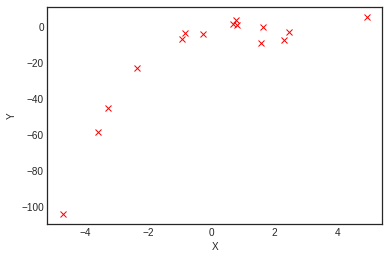

In [5]:
plt.plot(X, y, 'rx')
plt.xlabel("X")
plt.ylabel("Y")

In [6]:
bias_value = 1
X_ = np.hstack((np.full((m, 1), bias_value), X))
X_.shape

(15, 2)

In [7]:
poly_degree = 3
stacked_X = [X_]

for dg in range(2, poly_degree+1):
    stacked_X.append((X_[:, 1] ** dg).reshape((m, 1)))
    
X_ = np.hstack((
                    stacked_X
                ))
X_.shape

(15, 4)

karena kita ingin memprediksi $ y $, karena itu akan saya rubah istilahnya menjadi hypotesis $ h $.

In [8]:
class HypotesisFunction(object):
    def __call__(self, x_val, theta):
        # bisa gunakan np.dot: np.dot(x_val, theta)
        return x_val @ theta


***
Normalization dengan:

> $ { X }_{ j }:=\quad \frac { { X }_{ j }\quad -\quad { \mu  }_{ j } }{ { \sigma  }_{ j } } \quad for\quad x\quad in\quad 1... $

karena seperti bisa kita liat bersama, hasil X_ diatas rentangnya sangat beragam, dan agar memudahkan perhitungan kita samakan dulu rentang nilainya, proses ini biasa dinamakan dengan **Normalization** atau **Standardization**.

In [9]:
# silahkan coba dengan tidak menggunakan data normalization, teman-teman nanti
#   bisa merasakan betapa bergunanya data normalization itu.
start_pos = 1
def mean_normalization(x_val, start_pos=1):
    return (x_val[:, start_pos:] - np.mean(x_val[:, start_pos:], axis=0)) / np.std(x_val[:, start_pos:], axis=0)
X_[:, start_pos:] = mean_normalization(X_, start_pos)
print(X_.shape)
print(X_)

(15, 4)
[[ 1.         -1.27844688  0.5827071  -0.73707529]
 [ 1.          0.3404911  -0.75374886  0.08065322]
 [ 1.         -0.34628193 -0.72266014  0.05056532]
 [ 1.         -1.84445503  2.0851024  -2.31078129]
 [ 1.         -1.40130766  0.86325288 -0.98738529]
 [ 1.          1.97550094  2.3497034   2.77939786]
 [ 1.         -0.31227501 -0.74278034  0.05521714]
 [ 1.          0.99513647 -0.04834616  0.40303339]
 [ 1.          0.93799643 -0.1384938   0.34748243]
 [ 1.          0.32809733 -0.76018377  0.07934846]
 [ 1.          0.64449694 -0.5153962   0.156186  ]
 [ 1.         -0.91074066 -0.10594317 -0.22894025]
 [ 1.         -0.08787261 -0.82701082  0.06859289]
 [ 1.          0.67104833 -0.48723249  0.16785266]
 [ 1.          0.28861223 -0.77897003  0.07585275]]


In [10]:
def plot_learning_progress(x_val, y_real, y_pred, theta=None, mse=0., epoch=0, degree=0):
    plt.plot(x_val, y_real, 'rx')
    
    # sort the values of x before line plot
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x_val, y_pred), key=sort_axis)
    X_pred, y_pred = zip(*sorted_zip)
    # plot the line
    plt.plot(X_pred, y_pred, color='b', label='ℎ(x, w)=w.x')

    plt.legend(loc='lower right')
    if len(str(round(mse,2))) > 12:
        mse = float("NaN")
    plt.title('fit polynomial degree:{}, mse: {:.4f} | epoch: {}'.format(degree, mse, epoch))
    plt.show()

***
Loss function

Mean Absolute Error
> $$ J(\theta )=\frac { 1 }{ m } \sum _{ i=1 }^{ m } \left\| { { (h }_{ \theta  } } ({ x }^{ (i) })\quad -\quad { y }^{ (i) }{ ) } \right\|  $$

method of Least Square, least square error:
> $$ J(\theta )=\sum _{ i=1 }^{ m }{ { (h }_{ \theta  } } ({ x }^{ (i) })\quad -\quad { y }^{ (i) }{ ) }^{ 2 } $$

Mean Square Error
> $$ J(\theta )=\frac { 1 }{ m } \sum _{ i=1 }^{ m }{ { (h }_{ \theta  } } ({ x }^{ (i) })\quad -\quad { y }^{ (i) }{ ) }^{ 2 } $$

di beberapa literature denominator $ m $ dalam $ \frac { 1 }{ m } $ terkadang bisa langsung diberikan nilai 2 yang akhirnya menyatakan mean.

L2 regularization(Tikonov Regularization)
> $$ \frac { \lambda  }{ 2 } \sum _{ j=1 }^{ m }{ { \theta  }_{ j }^{ 2 } }  $$

In [11]:
# https://math.stackexchange.com/questions/884887/why-divide-by-2m

def J(y_pred, y_real, theta=None, regularized=False, lambd=1, m=None, loss_type='l2'):
    if m is None:
        m = y_pred.shape[0]
        
    if loss_type == 'l1':
        return np.average(np.abs(y_real - y_pred))
    else:
        if regularized:
            # l2 regularization
            magnitude = np.linalg.norm(theta) # cara lain: np.sqrt(weight.dot(weight))

            reg_term = (lambd/m) * np.square(magnitude)

            #return ((1/(2*m)) * np.square(np.subtract(y, predictions)).sum()) + reg_term
            return np.square(np.subtract(y_real, y_pred)).mean() + reg_term
        else:
            # MSE a.k.a mean of the sum of square error
            # => cara lain: np.square(np.subtract(y_real, y_pred)).mean(),
            #  tapi klo yg mirip rumus ini dibawah
            return ((1/(2*m)) * np.square(np.subtract(y_real, y_pred)).sum())

***

In [12]:
class Optimization(ABC):
    
    @abstractmethod
    def fit(self):
        return
    
class GradientDescent(Optimization):
    def __init__(self, lr=0.01, epoch=100, use_regularized=False, theta=None, **kwargs):
        assert lr!=0, 'Learning rate can not be null'
        
        self.lr = lr
        self.epoch = epoch
        self.use_regularized = use_regularized
        self.theta = theta
        self.kwargs = kwargs
    
    @abstractmethod
    def gradient(self):
        return
    
    def initWeight(self, shape, mu=0, sigma=0.1):
        return np.random.normal(mu, sigma, shape)
        
    def fit(self, X, y, loss_func, hypo_func):
        """Fit model."""
        lambd = self.kwargs.get('lambd', 1)
        loss_type = self.kwargs.get('loss_type', 'l2')
        
        # make prediction
        predictions = hypo_func(X, self.theta)

        # calculate loss
        step_loss = self.stepLost(loss_func, y_pred=predictions,
                                  y_real=y, theta=self.theta,
                                  regularized=self.use_regularized,
                                  lambd=lambd, loss_type=loss_type)

        # calculate gradient
        gradient = self.gradient(m=m, X=X, prediction=predictions, y=y)
        
        if self.use_regularized:
            reg_term = (lambd/2) * self.theta
        else:
            reg_term = 0

        # update weight
        self.theta -= self.lr * (gradient + reg_term)
        
        return step_loss, predictions, gradient
    
    @abstractmethod
    def stepLost(self):
        """calculate gradient step loss."""
        return
    
# terkadang orang menyebut learning_rate lr dengan alpha
# ini implementasi dari batch gradient descent, cocok untuk data kecil
#   untuk data lebih besar, pergunakan stochastic gradient descent
# sometimes kita bisa bilang batch GD sebagai vanila GD
class BatchGradientDescent(GradientDescent):
    
    def gradient(self, m=None, X=None, prediction=None, y=None):
        return (1/m) * (X.T @ (prediction - y))
        
    def stepLost(self, func, **kwargs):
        return func(**kwargs)
        
    def fit(self, x_val, y_val, loss_func, hypo_func, lambd=1, loss_type='l2'):
        m, n = x_val.shape

        if self.theta is None:
            self.theta = self.initWeight(n)
        
        self.init_w = copy.copy(self.theta)
        self.loss_hist = []
        self.gradient_hist = []

        for step in range(self.epoch):
            step_loss, predictions, \
                        gradient = super(BatchGradientDescent, self).fit(x_val, y_val,
                                                                         loss_func,
                                                                         hypo_func)
            self.loss_hist.append(step_loss)
            self.gradient_hist.append(gradient)

            if step%int(self.kwargs.get('plot_every',10))==0:
                plot_learning_progress(X, y_val, predictions, self.theta,
                                        mse=step_loss, epoch=step,
                                        degree=self.kwargs.get('degree',1))

        return self

***
#### Training dengan GD solutions

In [13]:
h = HypotesisFunction()

/home/aulianorman/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aulianorman/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8462 missing from current font.
  font.set_text(s, 0, flags=flags)


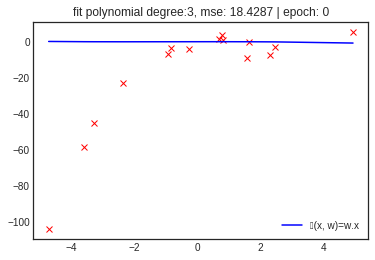

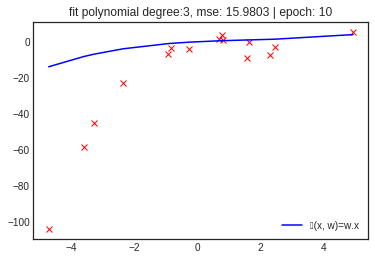

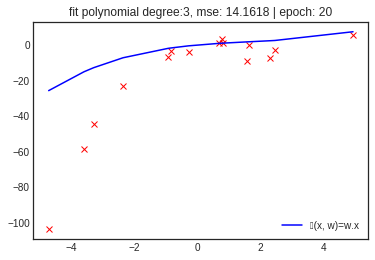

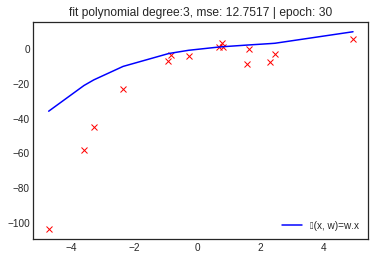

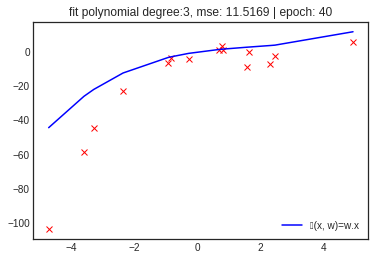

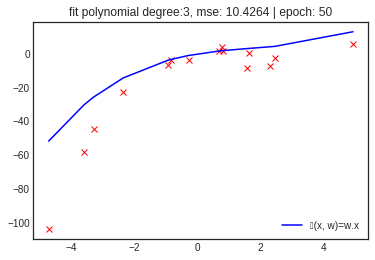

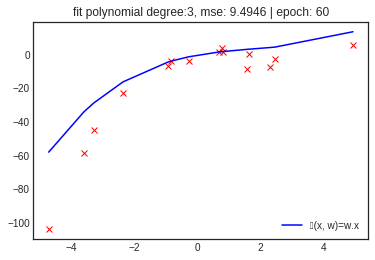

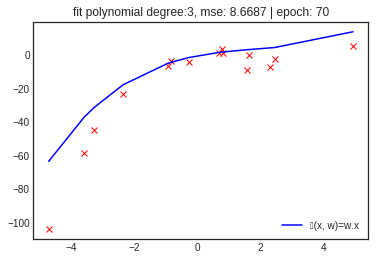

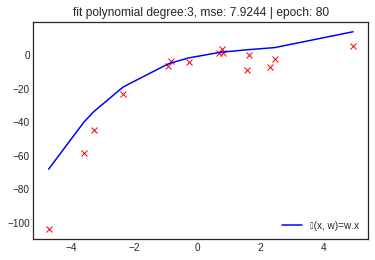

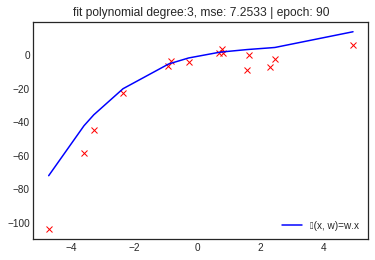

In [14]:
batchgd = BatchGradientDescent(lr=0.01, epoch=100,
                                plot_every=10, 
                                degree=poly_degree, loss_type='l1')
vanilagd = batchgd.fit(X_, y, J, h)

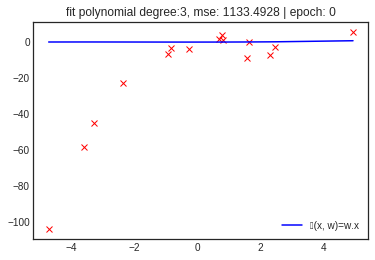

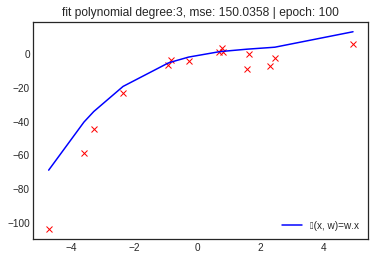

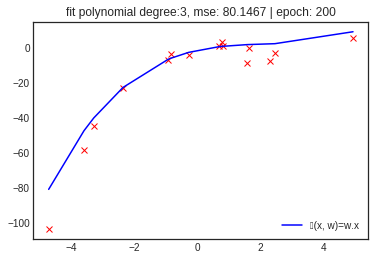

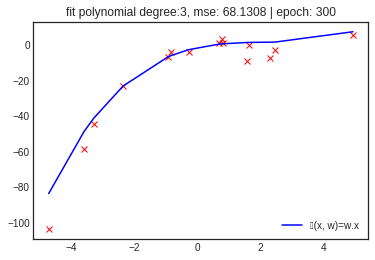

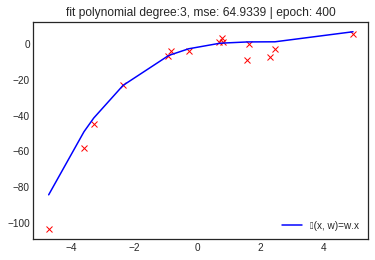

In [15]:
batchgd = BatchGradientDescent(lr=0.01, epoch=500,
                                use_regularized=True,
                                plot_every=100, lambd=0.5, 
                                degree=poly_degree, loss_type='l2')
vanilagd = batchgd.fit(X_, y, J, h)

***
#### Training dengan Closed/Normal-form solutions

In [16]:
class ClosedFormSolution(Optimization):
    def __init__(self, is_regularized=False):
        self.is_regularized = is_regularized

    def fit(self, X, y):
        return np.linalg.pinv(X_.T@X_) @ X_.T @ y
    
    def fit_reg(self, X, y, lambd=1):
        m,n = X.shape
        
        # get identity matrix
        I = np.eye((n))
        
        return np.linalg.pinv(X.T @ X + lambd * I) @ X.T @ y

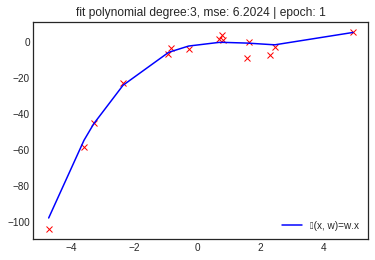

In [17]:
# https://stackoverflow.com/questions/34142485/difference-between-numpy-dot-and-python-3-5-matrix-multiplication
# https://math.stackexchange.com/questions/2354047/dot-product-versus-matrix-multiplication-is-the-later-a-special-case-of-the-fir

## Equal to np.linalg.pinv(np.dot(X_.T, X_)).dot(X_.T).dot(y)
cf_solutions = ClosedFormSolution()
theta = cf_solutions.fit_reg(X_, y, lambd=1)

predictions = h(X_, theta)
closeform_loss = J(y_pred=predictions, y_real=y, loss_type='l2')

plot_learning_progress(X, y, predictions, mse=closeform_loss, epoch=1, degree=poly_degree)

***
### Visualization
> Visualize gradient movement

In [ ]:
l = 1 #Complexity hyperparameter lambda = 25

#Setup of meshgrid of theta values
T1 = np.linspace(vanilagd.init_w[0] - 20 , vanilagd.init_w[0] + 20, 20)
T2 = np.linspace(vanilagd.init_w[1] - 40 , vanilagd.init_w[1] + 40, 40)
M, B = np.meshgrid(T1, T2)

#Computing the cost function for each theta combination
zs = np.array(  [J(h(X_, vanilagd.init_w),
                   y.reshape(-1,1),
                   np.array([t1,t2]).reshape(-1,1),l) 
                     for t1, t2 in zip(np.ravel(M), np.ravel(B)) ] )

#Reshaping the cost values    
Z = zs.reshape(M.shape)

theta_i = vanilagd.gradient_hist[-1]

#Plot the contour
fig1, ax1 = plt.subplots(figsize = (7,7))
ax1.contour(T1, T2, Z, 40, cmap = 'jet')

# Create animation
line, = ax1.plot([], [], 'r', label = 'Gradient descent', lw = 1.5)
point, = ax1.plot([], [], '*', color = 'red', markersize = 10)
value_display = ax1.text(0.02, 0.02, '', transform=ax1.transAxes)
value_title = ax1.set_title('Loss type:{}, degree:{}, lr:{}'.format('L1',2, 0.01))

def init_1():
    line.set_data([t[0] for t in vanilagd.gradient_hist], [t[1] for t in vanilagd.gradient_hist])
    point.set_data([theta_i[0]], [theta_i[1]])
    #value_display.set_text('Loss type:{}, degree:{}, lr:{}'.format('L1',2, 0.01))
    #value_title.set_title('Loss type:{}, degree:{}, lr:{}'.format('L1',2, 0.01))

    return line, point, value_display

def animate_1(i):
    # Animate line
    line.set_data(np.array(vanilagd.gradient_hist)[:,:1][:i], np.array(vanilagd.gradient_hist)[:,1:2][:i])
    
    # Animate points
    point.set_data(np.array(vanilagd.gradient_hist)[:,:1][i], np.array(vanilagd.gradient_hist)[:,1:2][i])

    # Animate value display
    value_display.set_text('Min = ' + str(vanilagd.loss_hist[i]))

    return line, point, value_display

ax1.legend(loc = 1)

anim1 = animation.FuncAnimation(fig1, animate_1, init_func=init_1,
                                frames=len(vanilagd.gradient_hist), interval=100, 
                                repeat_delay=60, blit=False)
#plt.show()
HTML(anim1.to_jshtml())

In [ ]:
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(M, B, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
#ax.plot([t[0] for t in vanilagd.gradient_hist],[t[1] for t in vanilagd.gradient_hist],vanilagd.loss_hist, marker = '*', color = 'r', alpha = .4, label = 'Gradient descent')

ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
ax.set_zlabel('error')
#ax.set_title('RSS gradient descent: Root at {}'.format(theta_result_reg.ravel()))
ax.view_init(45, -45)